<a href="https://colab.research.google.com/github/CraftyManiac/Retinal-Segmentation-UNet/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import sys
sys.path.append('/content/drive/Shared drives/Capstone Summer 2020/Collab Files/Scripts')

In [ ]:
# from SegLoss import GDiceLoss, GDiceLossV2, SSLoss, SoftDiceLoss, IoULoss, TverskyLoss, FocalTversky_loss, AsymLoss, DC_and_CE_loss, PenaltyGDiceLoss, DC_and_topk_loss, ExpLog_loss

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torch.optim as optim
from torch.utils.data import DataLoader

from torch.optim import lr_scheduler
from torch.utils.data import Dataset as BaseDataset
from torchvision.transforms import functional
from torchvision import transforms
from tqdm.notebook import tqdm 
import time

import albumentations as A
from albumentations.augmentations import transforms as a_transforms

# custom modules
from VisModel import VisModel
from UNet import UNet
from HybridLogisticDiceLoss import HybridLogisticDiceLoss, dice_metric, one_hot
# from mask_post_processing import post_process_mask

import random
random.seed(0xDEADBEEF)
np.random.seed(0xDEADBEEF)
torch.manual_seed(0xDEADBEEF)

In [ ]:
ROOT_PATH = 'drive/Shared drives/Capstone Summer 2020/Data/'

In [ ]:
print(len(os.listdir(ROOT_PATH + 'Training/Images')))
# for img in os.listdir(ROOT_PATH + 'Validation/Images'):
#   os.rename(ROOT_PATH + 'Validation/Images/'+ img, ROOT_PATH + 'Training/Images/' + img)

# for mask in os.listdir(ROOT_PATH + 'Validation/Masks'):
#   os.rename(ROOT_PATH + 'Validation/Masks/' + mask, ROOT_PATH + 'Training/Masks/'+ mask)

398


#Dataset

In [ ]:
# this dataset already contains the transforms
IMG_SIZE = (128, 128)
def fix_mask(mask):
  # mask[mask == 1] = 3
  # mask[mask == 0] = 1
  # mask[mask == 2] = 1 
  # mask[mask == 3] = 0
  mask[mask == 0] = 1
  mask[mask == 1] = 0
  mask[mask == 2] = 1 

  return mask


def normalize(data):
  m = torch.mean(data)
  s = torch.std(data)
  return (data - m) / s

def augment():
  return A.Compose([
                    # a_transforms.ElasticTransform(p=1),
                    a_transforms.RandomBrightnessContrast(),
                    a_transforms.RGBShift(),
                    a_transforms.RandomContrast(),
                    a_transforms.RandomGamma(),
                    a_transforms.RandomRotate90(),
                    a_transforms.Transpose(),
                    a_transforms.ShiftScaleRotate()
                    ])

class Dataset(BaseDataset):
  def __init__(self, root_dir, is_train=True):
    self.root_dir = root_dir
    self.images_dir = os.path.join(root_dir, 'Images')
    self.masks_dir = os.path.join(root_dir, 'Masks')
    self.ids = os.listdir(self.images_dir)
    self.maskids = os.listdir(self.masks_dir)
    self.is_train = is_train

  @classmethod
  def preprocess(cls, pil_img):
    # pil_img = pil_img.resize((128, 128), resample=Image.NEAREST)

    # img_nd = np.array(pil_img)
    img_nd = pil_img

    if len(img_nd.shape) == 2:
      img_nd = np.expand_dims(img_nd, axis=2)
  
    # HWC to CHW
    img_trans = img_nd.transpose((2, 0, 1))
    if img_trans.max() > 1:
      img_trans = img_trans / 255

    return img_trans
  

  def __getitem__(self, idx):
    #load images and masks
    img_path = os.path.join(self.images_dir, self.ids[idx])
    mask_path = os.path.join(self.masks_dir, self.maskids[idx])
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE, resample=Image.NEAREST)
    mask = Image.open(mask_path).resize(IMG_SIZE, resample=Image.NEAREST)

    # pil_img = pil_img.resize((128, 128), resample=Image.NEAREST)

    img = np.array(img)
    mask = np.array(mask)
    # if self.is_train:
    #   augmented = augment()(image=img, mask=mask)
    #   img = augmented['image']
    #   mask = augmented['mask']

    label = 0 if self.ids[idx][0] == 'n' else 1 # this isn't being used at the moment

    img = self.preprocess(img)
    mask = self.preprocess(mask)*2

    # print(img.min(), img.max())
    img = torch.from_numpy(img).type(torch.FloatTensor)
    mask = torch.from_numpy(mask).long()
    mask = fix_mask(mask)
    img = normalize(img)
    # print(img.min(), img.max())
    return img, mask 
  
  def __len__(self):
    return len(self.ids)

In [ ]:
# import the necessary packages
from imutils import contours
from skimage import measure
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow
import PIL
from matplotlib import pyplot as plt
import os


def noise_removal(image):
  '''
  - Noise Removal using erosion
  - Removal of small blobs under a certain threshold of pixels
  '''
  #Noise Removal

  image = cv2.erode(image, None, iterations=2)

  # perform a connected component analysis on the mask and
  # initialize a mask to store only the "large" components
  labels = measure.label(image, connectivity=2, background=0)
  mask = np.zeros(image.shape, dtype="uint8")

  # loop over the sub-masks
  for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
      continue
    # otherwise, construct the individual sub-mask and count the 
    # number of pixels 
    labelMask = np.zeros(image.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)

    # If the mask is smaller than the theshold, don't add it to the final mask
    if numPixels > 75:
      mask = cv2.add(mask, labelMask)
  return mask

def draw_ellipse(mask):
  contours, hierarchy = cv2.findContours(mask, 1, 2)
  # m3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
  has_ellipse = len(contours) > 0
  if has_ellipse:
    #Extracting the biggest contour
    biggest_cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    if (len(biggest_cnt) < 5): # To draw an ellipse, atleast 5 points are required
      # print("Return Original")
      return False, mask
    ellipse = cv2.fitEllipse(biggest_cnt)
    #Create a blank image
    mask = np.zeros(mask.shape, dtype="uint8")
    cv2.ellipse(mask, ellipse, (255, 255, 255), -1)
  return has_ellipse, mask

def post_process_mask(mask):
  '''
  Post processing includes noise removal and creating an elliptical fit
  for the input mask.  
  :param mask: One channel binary mask of type numpy array 
  :return: The elliptical fitted mask is returned
  '''
  # mask = cv2.imread(img_path, 0)
  # cv2_imshow(mask)

  denoised_mask = noise_removal(mask)
  # cv2_imshow(mask)

  has_ellipse, mask_with_ellipse = draw_ellipse(denoised_mask)
  if not has_ellipse:
    return mask
  # np.array(mask)
  # if has_ellipse:
  #   cv2_imshow(mask_with_ellipse)
  # else:
  #   print("No ellipse")
  #   cv2_imshow(mask_with_ellipse)
  return mask_with_ellipse

#Visualization Functions

In [ ]:
def decode_segmap(image, nc=3):
  im = Image.fromarray((1-image.astype(np.uint8))*255)
  im.save('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Images/'+ str(random.randint(10,1000000)), format='PNG')

  label_colors = np.array([(0, 0, 0), (130, 130, 130), (255, 255, 255)])
  if nc == 2:
    label_colors = np.array([(0, 0, 0), (255, 255, 255)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
def plot_curves(train_loss_list, valid_loss_list, dice_score_list, lr_rate_list):
 
  fig, axs = plt.subplots(1, 3, figsize=(22,5))

  axs[0].plot([i[0] for i in lr_rate_list])
  axs[0].set_ylabel('learing rate during training')
  axs[0].set_xlabel('epochs')

  axs[1].plot(train_loss_list, label="Training Loss")
  axs[1].plot(valid_loss_list, label="Validation Loss")
  axs[1].set_ylabel('loss')
  axs[1].set_xlabel('epochs')
  axs[1].legend()
  # dice_score = np.delete(np.asarray(dice_score_list), 2, 1)
  dice_score = np.asarray(dice_score_list)
  axs[2].plot(dice_score[:,0], label="OC")
  
  # axs[2].plot(dice_score[:,1], label="OD")
  axs[2].set_ylabel('Dice score')
  axs[2].set_xlabel('epochs')
  axs[2].legend()
  plt.show()


In [ ]:
def visualize_output_ellipse(dataset, target, n_imgs):
  dataset_size = len(dataset)
  for i in range(n_imgs):
    random_idx = random.randint(0, dataset_size)
    img = dataset[random_idx][0].to(device)
    gt = dataset[random_idx][1]
    with torch.no_grad():
      # result = model(img.unsqueeze(0))
      output = model(img.unsqueeze(0))
      result_img = torch.argmax(output, dim=1)[0]
      img = post_process_mask(result_img.cpu().numpy().astype('uint8') * 255) 
      img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0) //255
      img = one_hot(img.squeeze(1).long(), output.shape[1])
      
    dice_cof = dice_metric(img, target.cpu().numpy())
    # dice_cof = dice_metric(result, target.to(device)).cpu().numpy()
    mask = torch.argmax(output, dim=1)[0]
    mask = mask.detach().cpu().numpy()
    rgb = decode_segmap(torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy(), nc=2)

    # print(np.unique(torch.argmax(result.squeeze(), dim=0).detach().cpu().numpy()))
    # save_img = torchvision.transforms.functional.to_pil_image(rgb)
    # save_img.save('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Images/'+ str(i), format='JPEG')


    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    axs[0].imshow(gt.squeeze(0), cmap='gray')
    axs[0].axis('off')   
    axs[0].set_title('GT')  
    axs[1].imshow(rgb)
    axs[1].axis('off')   
    axs[1].set_title('Dice Score:'+  np.array_str(dice_cof[:-1], precision=3))
    plt.show()

def visualize_output(dataset, n_imgs):
  dataset_size = len(dataset)
  for i in range(n_imgs):
    random_idx = random.randint(0, dataset_size)
    img = dataset[random_idx][0].to(device)
    gt = dataset[random_idx][1]
    with torch.no_grad():
      result = model(img.unsqueeze(0))
     
    dice_cof = dice_metric(result, gt.to(device)).cpu().numpy()

    rgb = decode_segmap(torch.argmax(result.squeeze(), dim=0).detach().cpu().numpy(), nc=3)

    # print(np.unique(torch.argmax(result.squeeze(), dim=0).detach().cpu().numpy()))
    # save_img = torchvision.transforms.functional.to_pil_image(rgb)
    # save_img.save('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Images/'+ str(i), format='JPEG')


    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    axs[0].imshow(gt.squeeze(0), cmap='gray')
    axs[0].axis('off')   
    axs[0].set_title('GT')  
    axs[1].imshow(rgb)
    axs[1].axis('off')   
    axs[1].set_title('Dice Score:'+  np.array_str(dice_cof[:-1], precision=3))
    plt.show()

In [ ]:
def validate_model_ellipse(model):
  batch_size = 1
  test_dataset = Dataset(os.path.join(ROOT_PATH, 'Validation'), is_train=False)
  testing_size = len(test_dataset)
  print('Size of Validation:', testing_size)


  testing = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

  model.eval()

  dice = 0.0
  bar = tqdm(testing)
  for data, target in bar:
    data = data.to(device)
    # target = target.to(device)
    with torch.no_grad():
      output = model(data)
      result_img = torch.argmax(output, dim=1)[0]
      img = post_process_mask(result_img.cpu().numpy().astype('uint8') * 255) 
      img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0) //255
      img = one_hot(img.squeeze(1).long(), output.shape[1])
      
    dice_cof = dice_metric(img, target) * data.size(0)
    dice += dice_cof
  dice /= testing_size
  print('AVG Dice Score:', dice)
  visualize_output(test_dataset, target, 3)

def validate_model(model):
  batch_size = 1
  test_dataset = Dataset(os.path.join(ROOT_PATH, 'Validation'), is_train=False)
  testing_size = len(test_dataset)
  print('Size of Validation:', testing_size)


  testing = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

  model.eval()

  dice = 0.0
  bar = tqdm(testing)
  for data, target in bar:
    data = data.to(device)
    target = target.to(device)
    with torch.no_grad():
      output = model(data)
      
    dice_cof = dice_metric(output, target).cpu().numpy() * data.size(0)
    dice += dice_cof
  dice /= testing_size
  print('AVG Dice Score:', dice)
  visualize_output(test_dataset, 3)

n_train: 398 n_val: 398
[0 1]


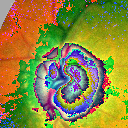

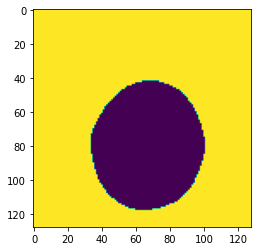

In [ ]:
batch_size = 4
datasets = {'Training': Dataset(os.path.join(ROOT_PATH, 'Training')),
            'Validation': Dataset(os.path.join(ROOT_PATH, 'Testing'), is_train=False)}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['Training', 'Validation']}
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Validation'] }
n_train = dataset_sizes['Training']
n_val = dataset_sizes['Validation']

print('n_train:', n_train,'n_val:', n_val)
# testing the gt
d = datasets['Training'][0][0]
m = datasets['Training'][0][1]
print(np.unique(m[0]))


# plt.imshow(d[0])
plt.imshow(m[0])
display(torchvision.transforms.functional.to_pil_image(d))


#Train

In [ ]:
def train_model(model, criterion, optimizer, scheduler, save_file, n_epochs = 3, ):
  start = time.time()
  train_loss_list = []
  valid_loss_list = []
  dice_score_list = []
  lr_rate_list = []
  valid_loss_min = np.Inf # track change in validation loss
  best_epoch = 0

  

  for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    best_model = model
    ###################
    # train the model #
    ###################
    model.train()
    bar = tqdm(dataloaders['Training'], postfix={"train_loss":0.0})
    for data, target in bar:
      # move tensors to GPU if CUDA is available

      data, target = data.to(device), target.to(device)

      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model

      output = model(data)

      # output = nn.Softmax(dim=1)(output)

      # calculate the batch loss
      loss = criterion(output, target.squeeze(1).type(torch.long))
      
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*data.size(0)
      bar.set_postfix(ordered_dict={"train_loss":loss.item()})

    ######################    
    # validate the model #
    ######################
    model.eval()
    # del data, target
    with torch.no_grad():
      bar = tqdm(dataloaders['Validation'], postfix={"valid_loss":0.0, "dice_score":0.0})
      for data, target in bar:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # output = nn.Softmax(dim=1)(output)
        # calculate the batch loss
        loss = criterion(output, target.squeeze(1).type(torch.long))
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        # dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
        dice_cof = dice_metric(output, target).cpu().numpy()
        dice_score +=  dice_cof * data.size(0)
        bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/n_train
    valid_loss = valid_loss/n_val
    dice_score = dice_score/n_val
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        best_epoch = epoch
        best_model_dict = model.state_dict()
        torch.save(best_model_dict, 'drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/best_' + save_file + '.pt')
        valid_loss_min = valid_loss
    
    # scheduler.step(dice_score[0]*100)
    # scheduler.step(100 * torch.mean(torch.from_numpy(dice_score[:-1]).type(torch.FloatTensor)))
    scheduler.step()

  time_elapsed = time.time() - start
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  torch.save(model.state_dict(), 'drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Final_' + save_file + '.pth')

  return model, best_model_dict, best_epoch, train_loss_list, valid_loss_list, dice_score_list, lr_rate_list

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(3, 2)

model.to(device)

lr = 0.00039
# lr = 0.00025

criterion = nn.CrossEntropyLoss()
# criterion = HybridLogisticDiceLoss()
# criterion = FocalLoss() # requires a larger lr

# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)
# optimizer = optim.Adagrad(model.parameters(), lr=lr, weight_decay=1e-2)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-2)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
# exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=0)

In [ ]:
# save_file = loss +'_' + opt + '_' + sched
save_file = 'CrossEntropy' +'_' + 'SGD ' + '_' + 'StepLR'
model, best_model_dict, best_epoch, train_loss_list, valid_loss_list, dice_score_list, lr_rate_list = train_model(model, criterion, optimizer, exp_lr_scheduler, save_file, n_epochs=40)


Epoch: 1  Training Loss: 0.179580  Validation Loss: 0.119006 Dice Score: [0.81063676 0.9783808 ]
Validation loss decreased (inf --> 0.119006).  Saving model ...



Epoch: 2  Training Loss: 0.078700  Validation Loss: 0.184604 Dice Score: [0.4458893  0.96259886]



Epoch: 3  Training Loss: 0.067042  Validation Loss: 0.176453 Dice Score: [0.5364333 0.9671147]



Epoch: 4  Training Loss: 0.060664  Validation Loss: 0.198605 Dice Score: [0.43921953 0.9624345 ]



Epoch: 5  Training Loss: 0.057320  Validation Loss: 0.173487 Dice Score: [0.5377891 0.9647591]



Epoch: 6  Training Loss: 0.054015  Validation Loss: 0.151836 Dice Score: [0.613109  0.9680088]



Epoch: 7  Training Loss: 0.051826  Validation Loss: 0.153068 Dice Score: [0.61564845 0.9707211 ]



Epoch: 8  Training Loss: 0.051430  Validation Loss: 0.100883 Dice Score: [0.8081646  0.97989714]
Validation loss decreased (0.119006 --> 0.100883).  Saving model ...



Epoch: 9  Training Loss: 0.047512  Validation Loss: 0.133232 Dice Score: [0.7160641 0.9763724]



Epoch: 10  Training Loss: 0.048775  Validation Loss: 0.168607 Dice Score: [0.57494724 0.9705182 ]



Epoch: 11  Training Loss: 0.046759  Validation Loss: 0.100284 Dice Score: [0.8032224 0.980741 ]
Validation loss decreased (0.100883 --> 0.100284).  Saving model ...



Epoch: 12  Training Loss: 0.045594  Validation Loss: 0.114462 Dice Score: [0.793454  0.9791425]



Epoch: 13  Training Loss: 0.045425  Validation Loss: 0.102747 Dice Score: [0.8381626 0.9802937]



Epoch: 14  Training Loss: 0.044896  Validation Loss: 0.109413 Dice Score: [0.79958695 0.97953254]



Epoch: 15  Training Loss: 0.043182  Validation Loss: 0.133785 Dice Score: [0.811743  0.9745591]



Epoch: 16  Training Loss: 0.043053  Validation Loss: 0.111262 Dice Score: [0.81803644 0.97990847]



Epoch: 17  Training Loss: 0.041632  Validation Loss: 0.132339 Dice Score: [0.74493545 0.97787136]



Epoch: 18  Training Loss: 0.041659  Validation Loss: 0.137140 Dice Score: [0.8113187 0.9739519]



Epoch: 19  Training Loss: 0.042177  Validation Loss: 0.124128 Dice Score: [0.82515574 0.9767928 ]



Epoch: 20  Training Loss: 0.041098  Validation Loss: 0.109508 Dice Score: [0.83108985 0.9801966 ]



Epoch: 21  Training Loss: 0.040491  Validation Loss: 0.112861 Dice Score: [0.83400667 0.9785862 ]



Epoch: 22  Training Loss: 0.040861  Validation Loss: 0.112084 Dice Score: [0.8302582 0.9801997]



Epoch: 23  Training Loss: 0.039161  Validation Loss: 0.127857 Dice Score: [0.8260406 0.9767913]



Epoch: 24  Training Loss: 0.042042  Validation Loss: 0.120498 Dice Score: [0.78563356 0.9793651 ]



Epoch: 25  Training Loss: 0.040467  Validation Loss: 0.102843 Dice Score: [0.8433371  0.98186207]



Epoch: 26  Training Loss: 0.039501  Validation Loss: 0.128350 Dice Score: [0.8258515  0.97674096]



Epoch: 27  Training Loss: 0.038605  Validation Loss: 0.114461 Dice Score: [0.826999  0.9798176]



Epoch: 28  Training Loss: 0.038203  Validation Loss: 0.115713 Dice Score: [0.83847636 0.9797645 ]



Epoch: 29  Training Loss: 0.038509  Validation Loss: 0.113580 Dice Score: [0.842412   0.98037726]



Epoch: 30  Training Loss: 0.038617  Validation Loss: 0.122080 Dice Score: [0.83627164 0.97840345]



Epoch: 31  Training Loss: 0.038162  Validation Loss: 0.131718 Dice Score: [0.82793355 0.9767993 ]



Epoch: 32  Training Loss: 0.037487  Validation Loss: 0.116636 Dice Score: [0.84246844 0.97944784]



Epoch: 33  Training Loss: 0.038068  Validation Loss: 0.111492 Dice Score: [0.8489422 0.98079  ]



Epoch: 34  Training Loss: 0.037532  Validation Loss: 0.110679 Dice Score: [0.8486588  0.98078054]



Epoch: 35  Training Loss: 0.037429  Validation Loss: 0.122994 Dice Score: [0.835182  0.9782905]



Epoch: 36  Training Loss: 0.037119  Validation Loss: 0.151494 Dice Score: [0.8056578  0.97255844]



Epoch: 37  Training Loss: 0.037393  Validation Loss: 0.110319 Dice Score: [0.8509671 0.9814188]



Epoch: 38  Training Loss: 0.036206  Validation Loss: 0.112477 Dice Score: [0.84243166 0.9810872 ]



Epoch: 39  Training Loss: 0.036998  Validation Loss: 0.122494 Dice Score: [0.8392914 0.9787613]



Epoch: 40  Training Loss: 0.035728  Validation Loss: 0.127249 Dice Score: [0.83503085 0.97794044]
Training complete in 8m 52s


#Results

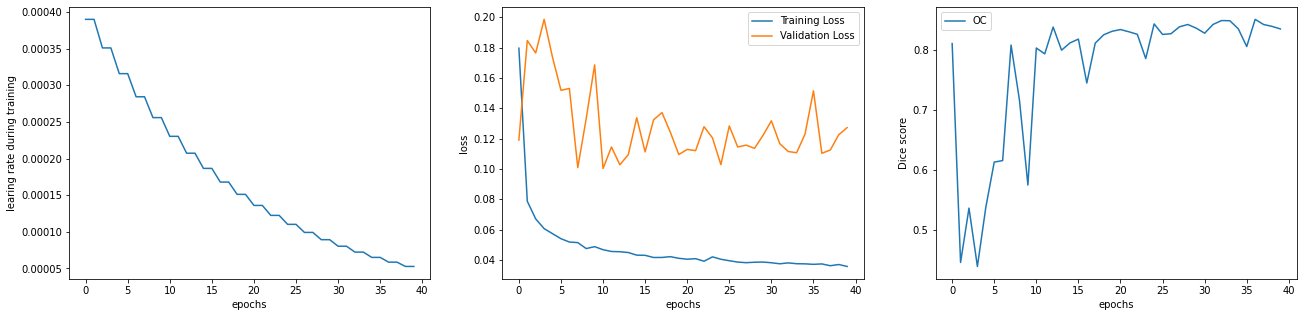

Best Epoch 11
Size of Validation: 398



AVG Dice Score: [0.8911664 0.9855165]


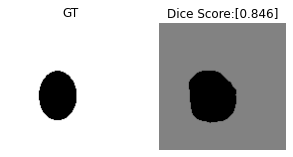

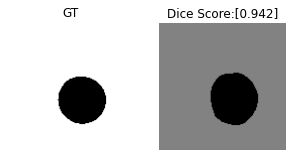

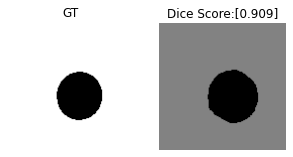

In [ ]:
plot_curves(train_loss_list, valid_loss_list, dice_score_list, lr_rate_list)
print('Best Epoch', best_epoch)


best_model = UNet(3, 2)
best_model.load_state_dict(best_model_dict)
best_model.to(device)
validate_model(best_model)
# validate_model_ellipse(best_model)

In [ ]:
# load best model
# model = UNet(3,3)

# model.load_state_dict(torch.load('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Laroy_UNet-Crop.pth')) # this is the final epoch saved
# # model.load_state_dict(torch.load('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/model_cifar.pt')) # This is the best model saved!
# model.to(device)
# print()

In [ ]:
# plot_curves(train_loss_list, valid_loss_list, dice_score_list, lr_rate_list)

In [ ]:
# validate_model(model)

In [ ]:
# model.to(device)
# model.load_state_dict(torch.load('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Laroy_UNet-Crop.pth'))

VisModel(model, criterion, optimizer, device, datasets, dataset_sizes)

interactive(children=(Dropdown(description='instance_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

In [ ]:
# imageName = "V0001"
# folderName= "Validation"

# img_path = "drive/Shared drives/Capstone Summer 2020/Data/"+ folderName +"/Images/"+ imageName +".jpg"
# img = np.array(Image.open(img_path).convert("RGB").resize(IMG_SIZE, resample=Image.NEAREST))

# img = torch.from_numpy(Dataset.preprocess(img))
# img = img.to(device)
# img = img.type(torch.cuda.FloatTensor)
# img = img.unsqueeze(0)

# img = normalize(img)

# mask_path = "drive/Shared drives/Capstone Summer 2020/Data/"+ folderName +"/Masks/"+ imageName +".bmp"
# ground_truth = np.array(Image.open(mask_path).resize(IMG_SIZE, resample=Image.NEAREST))

# ground_truth = Dataset.preprocess(ground_truth)*2

# # ground_truth = ground_truth.resize((408, 408), resample=Image.NEAREST)
# # ground_truth = fix_mask(np.array(ground_truth))
# ground_truth = torch.from_numpy(ground_truth).long()[0]
# print("UNIQUE MASK:", np.unique(ground_truth))

# with torch.no_grad():
#   result = model(img)

# mask = torch.argmax(result, dim=1)

# mask = mask[0]

# full_mask = mask.detach().cpu().numpy()

# rgb = decode_segmap(torch.argmax(result.squeeze(), dim=0).detach().cpu().numpy(), nc=3)

# plt.imshow(rgb)


# #Plotting all predicted masks
# ch1_mask = result[0][0].detach().cpu().numpy()
# ch2_mask = result[0][1].detach().cpu().numpy()
# ch3_mask = result[0][2].detach().cpu().numpy()

# fig, axs = plt.subplots(1, 4, figsize=(22,5))


# #plot original image
# axs[0].imshow((ch1_mask), cmap='gray')
# axs[0].axis('off')   
# axs[0].set_title('Ch 1')

# #plot ground truth
# axs[1].imshow((ch2_mask), cmap='gray')
# axs[1].axis('off')   
# axs[1].set_title('Ch 2')

# #plot the mask
# axs[2].imshow((ch3_mask), cmap='gray')
# axs[2].axis('off')   
# axs[2].set_title('Ch 3')

# axs[3].imshow((ground_truth), cmap='gray')
# axs[3].axis('off')   
# axs[3].set_title('GT')
# print('Dice Score:', dice_metric(result, ground_truth.unsqueeze(0).unsqueeze(0).to(device)).cpu().numpy())